In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime
#turns seconds into a string format ffmpeg uses
def seconds_formatter(sec):
    x = "0" + str(datetime.timedelta(seconds=sec))[:-3]
    return x

## Random Forest Classifier
identify reaches, successes, failures

# Project Variables 
### Change as needed.

In [213]:
df = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\goprolensfront-vj-2019-06-25\videos\A_copiedDeepCut_resnet50_goprolensfrontJun25shuffle1_60002.h5")
#remove extra level "scorer"
df.columns = df.columns.droplevel()


frame_rate = 119.88

total_num_frames = df.shape[0]

cols = ['Nose', 'DomInside', 'Pellet', 'Index', 'OtherHand']

classes = ['n', 's', 'f', 'r']

frames_before = 15

frames_after = 45

step_size = 1

seed = 79

In [214]:
def frame_to_time(frame):
    return round(frame/frame_rate, 3)
def time_to_frame(time):
    return int(round(time*frame_rate))

### Functions for Creating Classifier

In [215]:
import random
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#Functions to get training data
def get_dataset(df, start_frames):
    print(df.shape)
    dataframe = df[cols]
    dataset = []
    for start_f in start_frames:
        temp_df = dataframe.iloc[start_f - frames_before: start_f + frames_after]
        if len(temp_df.values.flatten()) == 0:
            print("FAILLLL")
        dataset.append(temp_df.values.flatten())
    return np.asarray(dataset)
def get_non_reach_frames(df, num_frames, blacklist, avoidance_radius):
    non_reaches = []
    random.seed(seed)
    while len(non_reaches) < num_frames:
        #hard code 3 non-reaches
        frame = random.randint(frames_before+10, df.shape[0] - frames_after-10)

        too_close = False
        for start_time in blacklist:
            if abs(frame - start_time) < avoidance_radius:
                print('no')
                too_close = True
                break
        if not too_close:
            non_reaches.append(frame)
    return non_reaches

#Use training features and labels to create Random Forest Classifier
def create_classifier(features, labels, n_trees, test_proportion=0.25, depth=None, max_feats='auto'):
    train_feats, test_feats, train_labs, test_labs = train_test_split(features, labels, test_size = test_proportion, random_state = seed)
    print('Training Features Shape:', train_feats.shape)
    print('Training Labels Shape:', train_labs.shape)
    print('Testing Features Shape:', test_feats.shape)
    print('Testing Labels Shape:', test_labs.shape)
    rf = RandomForestClassifier(n_estimators = n_trees, random_state = seed, max_depth=depth, max_features=max_feats)
    # Train the model on training data
    print(train_feats.shape)
    print(train_labs.shape)
    rf.fit(train_feats, train_labs)
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_feats)
    print(predictions)
    print(test_labs)
    wrong_labels = []
#     for i in range(len(predictions)):
#         if predictions[i] != test_labs[i]:
#             frame = -1
#             for key in frame_to_features.keys():
#                 if (frame_to_features[key] == test_feats[i]).all():
#                     frame = key
#                     break
#             wrong_labels.append((frame_to_time(frame), predictions[i], test_labs[i]))
    for i in range(len(predictions)):
        if predictions[i] != test_labs[i]:
            frame = -1
            wrong_labels.append((predictions[i], test_labs[i]))
    print('Wrong Labels', wrong_labels)
    return rf, wrong_labels

### Training Data

In [216]:
pm = 0
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None
#"C:\Users\vjj14\Documents\GoProLens\3lens\gp2.7k3lensA1.mp4"
df_A = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\gp2.7k3lensA1DeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
df_A.columns = df_A.columns.droplevel()
reach_times = [19.12, 23.752, 24.186, 24.630, 36.846, 43.652, 44.042, 46.964, 60.218, 62.897, 64.787, 72.045, 85.174, 88.196, 
           91.652, 93.248, 93.814, 106.294, 106.867, 111.344, 112.249, 113.407, 115.474, 115.918, 129.119, 136.837, 138.581]
reach_frames = [time_to_frame(x) for x in reach_times]
reach_labels = ['r', 'f', 'r', 'r', 's', 'f', 's', 'r', 's', 'r', 'r', 'r', 's', 'r', 's', 'r', 'r', 'r', 'f', 'r', 'r', 
                      'r', 'f', 'r', 's', 'r', 'r']
non_reaches_frames = get_non_reach_frames(df_A, len(reach_frames)//2, reach_frames, 12)
featuresA = get_dataset(df_A, reach_frames+non_reaches_frames)
labelsA = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

#"D:\DCIM\100GOPRO\2019.07.08_CC42970_N2_V3_2.7k_120FPS_Label_copy.mp4"
df_n2v3 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N2_V3_2.7k_120FPS_Label_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
df_n2v3.columns = df_n2v3.columns.droplevel()
reach_times = [12.325, 16.568, 17.55, 18.912, 20.41, 22.1, 22.92, 24.699, 27.4, 29.754, 30.431, 31.39, 32.692, 37.731, 
           38.258, 42.86, 45.714, 56.45, 76.803, 77.86, 86.2, 86.75, 91.13, 91.649, 97.563, 98.1, 106.739, 107.292, 116.412, 
           121.49, 122.236, 124.775, 125.375, 134.324, 134.859, 142.37, 143.0, 150.0, 159.435, 160.04, 165.02, 
           165.633, 174.018, 177.129, 179.23, 183.719, 185.755, 192.041, 197.214, 198.66, 201.286, 203.34, 204.15, 206.253, 
           209.36, 213.027, 213.895, 217.676, 218.325, 218.982, 223.198, 226.56, 230.524, 233.61, 234.286, 235.838, 236.316, 
           237.091, 250.448, 251.206, 253.05]
reach_frames = [time_to_frame(x) for x in reach_times]

reach_labels = ['s', 'r', 'f', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'r', 'r', 's', 'r', 'f', 'r', 
                  'f', 'r', 'f', 'r', 'f', 'r', 'f', 'r', 'f', 'r', 'r', 'f', 'r', 'f', 'r', 'f', 'r', 'f', 'f', 'r', 
                  'f', 'r', 's', 'r', 's', 'f', 'r', 's', 'f', 'r', 'f', 'r', 'r', 's', 'r', 'f', 'r', 'r', 'f', 'r', 's', 
                  'r', 's', 'r', 'r', 'f', 'f', 'r', 'f', 'r', 'r']
non_reaches_frames = get_non_reach_frames(df_n2v3, len(reach_frames)//2, reach_frames, 12)
features_n2v3 = get_dataset(df_n2v3, reach_frames+non_reaches_frames)
labels_n2v3 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

#"D:\DCIM\100GOPRO\2019.07.08_CC42970_N3_V3_2.7k_120FPS_Label_copy.mp4"
df_n3v3 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N3_V3_2.7k_120FPS_Label_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
df_n3v3.columns = df_n3v3.columns.droplevel()
reach_times = ['11.589', '17.755', '18.474', '20.810', '22.457', '25.491', '37.403', '41.884', '51.558', '57.359', 
                         '64.503', '78.54', '84.611', '96.276', '108.619', '117.017', '123.131', '130.131', '157.557', 
                         '164.342', '207.559']
reach_frames = [time_to_frame(float(x)) for x in reach_times]
reach_labels = ['s', 'f', 'r', 'r', 'r', 's', 'f', 's', 'f', 's', 'f', 'f', 's', 'f', 's', 's', 'f', 'f', 's', 
                          's', 'f']
non_reaches_times = [3.333, 126.886, 133.355, 205.494, 77.901, 94.947, 26.119, 73.896, 166.391, 51.277, 5.579, 16.697, 19.257, 22.71, 28.645, 31.2]
non_reaches_frames = [time_to_frame(x) for x in non_reaches_times]
features_n3v3 = get_dataset(df_n3v3, reach_frames+non_reaches_frames)
labels_n3v3 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

#"D:\DCIM\100GOPRO\2019.07.08_CC42973_N2INJURED_V3_2.7k_120FPS_Label.MP4"
df_injuredn2v3 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42973_N2INJURED_V3_2.7k_120FPS_Label_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
df_injuredn2v3.columns = df_injuredn2v3.columns.droplevel()
reach_times = ['21.196', '66.492', '71.227', '88.349', '92.221', '99.692', '116.299', '127.703', '135.332', 
                                '142.429', '147.11', '151.609', '157.722', '163.4', '172.798', '183.103', '204.054', '208.735', '216.329']
reach_frames = [time_to_frame(float(x)) for x in reach_times]
reach_labels = ['f', 's', 'f', 'f', 'r', 'f', 'f', 's', 'f', 'f', 's', 's', 's', 's', 'f', 'f', 'f', 'f', 's']
non_reaches_times = [157.463, 38.734, 62.743, 66.176, 88.856, 94.266, 171.907, 179.534, 184.588, 207.388, 72.36, 86.4, 88.5, 90.172]
non_reaches_frames = [time_to_frame(x) for x in non_reaches_times]
features_injuredn2v3 = get_dataset(df_injuredn2v3, reach_frames+non_reaches_frames)
labels_injuredn2v3 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

#"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N2_V2_2.7k_120FPS_rf_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5"
df_n2v2 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N2_V2_2.7k_120FPS_rf_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
df_n2v2.columns = df_n2v2.columns.droplevel()
reach_times = ['14.711', '32.655', '42.082', '42.718', '50.958', '53.474', '54.719', '55.383', '55.788', '57.26', '58.26', 
               '62.387', '62.965', '64.111', '70.942', '77.294', '77.84', '78.877', '80.16', '81.473', '82.164', '83.054', 
               '87.903', '93.567', '94.042', '94.689', '100.837', '101.711', '102.704', '111.962', '112.742', '118.758', 
               '127.66', '128.541', '129.396', '134.4', '138.618', '139.764', '140.528', '142.385', '142.960', '143.816', 
               '145.012', '149.907', '150.44', '151.57', '152.573', '170.386', '171.026', '176.764', '177.220', '179.808', 
               '192.836', '197.232', '198.342', '198.911', '199.796']
reach_frames = [time_to_frame(float(x)) for x in reach_times]
reach_labels = ['f', 'f', 'f', 'f', 'r', 'f', 'f', 'f', 'f', 'f', 'r', 'f', 'f', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'f', 
                     'r', 's', 'f', 'f', 'r', 'f', 'r', 'r', 'f', 'r', 'f', 'f', 'r', 'r', 's', 'r', 'r', 'r', 'f', 'f', 'r', 
                     'r', 'f', 'r', 'r', 'r', 'f', 'r', 'f', 'r', 'r', 's', 'r', 'f', 'f', 'r']
non_reaches_times = get_non_reach_frames(df_n2v2, len(reach_frames)//2, reach_frames, 12)
non_reaches_frames = [time_to_frame(x) for x in non_reaches_times]
non_reaches_frames = []
features_n2v2 = get_dataset(df_n2v2, reach_frames+non_reaches_frames)
labels_n2v2 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

# #Left handed
# #??????
# # df_n1v2 = pd.read_hdf()
# # df_n1v2.columns = df_n1v2.columns.droplevel()
# reach_times = ['1.923', '2.850', '5.226', '5.620', '12.312', '20.540', '23.473', '24.856', '25.37', '29.487', 
#         '33.058', '34.929', '39.422','39.930', '40.528', '40.955', '52.772', '76.416', '89.048','115.462', 
#         '125.123', '137.004', '160.532', '172.26', '220.833', '230.798', '240.640', '246.108','256.624',
#         '270.936', '293.789', '303.168', '459.340', '510.407', '519.217', '519.513']
# reach_frames = [time_to_frame(float(x)) for x in reach_times]
# reach_labels = ['r', 'r', 'f', 's', 'r', 'r', 'r', 'r', 'r', 's', 'r', 'r?', 'r', 'r', 'r', 'r', 'f', 'f', 's', 'f', 
#          's', 's', 's', 'f', 'f', 's', 'f', 'r', 's', 'f', 'f', 'f', 's', 's', 'f', 's']
# non_reaches_times = 
# non_reaches_frames = [time_to_frame(x) for x in non_reaches_times]
# features_n1v2 = get_dataset(df_n1v2, reach_frames+non_reaches_frames)
# labels_n1v2 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
# reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

#"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42973_N2INJURED_V1_2.7k_120FPS_rf_trim_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5"
df_injuredn2v1 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42973_N2INJURED_V1_2.7k_120FPS_rf_trim_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
df_injuredn2v1.columns = df_injuredn2v1.columns.droplevel()
reach_times =  ['5.384', '5.929', '20.437', '24.076', '24.565', '34.586', '35.160', '44.708', '45.297', '49.574', 
        '54.857', '62.150', '62.78', '67.446', '67.734', '84.11', '93.654', '94.114', '94.849', '102.198', 
        '107.123', '111.213', '119.381', '132.425', '140.596', '147.813', '161.0']
reach_frames = [time_to_frame(float(x)) for x in reach_times]
reach_labels = ['f', 'r', 'r', 'f', 'r', 'f', 'r', 'f', 'r', 'f', 's', 'f', 'f', 'f', 'r', 'f', 'f', 'f', 'r', 'f', 
         's', 'f', 'f', 's', 'f', 'f', 's']
non_reaches_times = []
non_reaches_frames = [time_to_frame(x) for x in non_reaches_times]
features_injuredn2v1 = get_dataset(df_injuredn2v1, reach_frames+non_reaches_frames)
labels_injuredn2v1 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

#??????"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42973_N2INJURED_V4_2.7k_120FPS_rf_trim_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5"
df_injuredn2v4 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42973_N2INJURED_V4_2.7k_120FPS_rf_trim_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
df_injuredn2v4.columns = df_injuredn2v4.columns.droplevel()
reach_times = ['1.093', '7.330', '7.65', '14.433', '20.814', '24.928', '30.84', '35.268', '42.592', '47.269', 
               '54.334', '58.980', '65.483', '66.179', '85.683']
reach_frames = [time_to_frame(float(x)) for x in reach_times]
reach_labels = ['s', 'f', 's?', 'f', 'f', 's', 'f', 'f', 's', 'f', 's', 'f', 'f', 'f', 'f']
non_reaches_times = []
non_reaches_frames = [time_to_frame(x) for x in non_reaches_times]
features_injuredn2v4 = get_dataset(df_injuredn2v4, reach_frames+non_reaches_frames)
labels_injuredn2v4 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None


(17061, 27)
no
no
(30598, 27)
(25677, 27)
(26534, 27)
no
no
(25265, 27)
(19897, 27)
(10786, 27)


In [217]:
compiled_features = np.concatenate((featuresA, features_n2v3, features_n3v3, features_injuredn2v3, features_n2v2, features_injuredn2v1, features_injuredn2v4))
compiled_labels = np.concatenate((labelsA, labels_n2v3, labels_n3v3, labels_injuredn2v3, labels_n2v2, labels_injuredn2v1, labels_injuredn2v4))
attempt_classifier = create_classifier(compiled_features, compiled_labels, 1000, test_proportion=0.01)[0]

Training Features Shape: (311, 900)
Training Labels Shape: (311,)
Testing Features Shape: (4, 900)
Testing Labels Shape: (4,)
(311, 900)
(311,)
['r' 's' 'f' 'r']
['r' 's' 'f' 'r']
Wrong Labels []


# Find Success, Fails, and Reaches

In [218]:
# wrong_ones = []
# for i in range(100, 200):
#     print(i)
#     seed = i
#     wrong_ones.extend(create_classifier(compiled_features, compiled_labels, 200, test_proportion=0.25)[1])
# wrong_ones.sort(key= lambda x: x[0])
# wrong_df = pd.DataFrame(wrong_ones, columns = ['guess', 'actual'])
# wrong_df.groupby(wrong_df.columns.tolist(),as_index=False).size()

In [219]:
from statistics import mode, StatisticsError
#Helper Functions
def get_predicted_times(classifier, df):
    dataframe = df[cols]
    inputs = []
    num_frames = frames_before + frames_after
    print('hihihihi')
    print(frames_before)
    print(frames_after)
    for index in range(num_frames, dataframe.shape[0] - num_frames, step_size):
        temp_df = dataframe.iloc[index - frames_before: index + frames_after]
        inputs.append(temp_df.values.flatten())
    inputs = np.asarray(inputs)
    predictions = classifier.predict(inputs)
    return predictions, list(range(num_frames, dataframe.shape[0] - num_frames, step_size))
def get_starts(lst):
    def most_common(l):
        try:
            return [mode(l)]
        except StatisticsError as e:
            # will only return the first element if no unique mode found
            if 'no unique mode' in e.args[0]:
                print("TIE: ", l)
                return [l[0]]
            # this is for "StatisticsError: no mode for empty data"
            # after calling mode([])
    lst = [(frame_to_time(x[0]), x[1]) for x in lst if x[1] != 'n']
    print(lst[0])
    lst.insert(0, (-999, 'sentinel'))
    starts = []
    run = 0
    classes_list = []
    for i in range(0, len(lst)):
        run += 1
        if lst[i][1] != 'sentinel':
            classes_list.append(lst[i][1])
        if lst[i][0] - lst[i-1][0] > .2:
            starts.append((lst[i][0], most_common(classes_list), classes_list))
            classes_list = []
            run = 0
    return starts

#Find Reaches, 
def get_classified_starts(classifier, df):
    predictions2, start_frames = get_predicted_times(classifier, df)
    class_to_predictions = {}
    return get_starts(list(zip(start_frames, predictions2)))
#     for start, prediction in zip(start_frames, predictions2):
#         for c in classes:
#             if prediction == c:
#                 if c in class_to_predictions.keys():
#                     class_to_predictions[c].append(frame_to_time(start))
#                 else:
#                     class_to_predictions[c] = [frame_to_time(start)]
#     for c in classes:
#         hold = get_starts(class_to_predictions[c])
#         class_to_predictions[c] = hold
#     return class_to_predictions


In [220]:
test_df = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N3_V2_2.7k_120FPS_analyze_trimDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
test_df.columns = test_df.columns.droplevel()
starts = get_classified_starts(attempt_classifier, test_df)
print(starts)
print(len(starts))
print([(x[0], x[2][-1]) for x in starts])
predicted_fails = [x[0] for x in starts if 'f' in x[1]]
predicted_reaches = [x[0] for x in starts if 'r' in x[1]]
predicted_successes = [x[0] for x in starts if 's' in x[1]]
print(predicted_fails)
print(predicted_reaches)
print(predicted_successes)
summ = 0
for x in starts:
    summ = summ + len(x[2])
print(summ/len(starts))

hihihihi
15
45
(1.96, 'r')
[(1.96, ['r'], ['r']), (3.312, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'f']), (4.613, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r']), (5.998, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (10.252, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'f', 'f', 'f', 'f']), (11.395

In [221]:
test_labels = ['r', 'f', 'r', 'r', 'f', 'f', 'r', 'r', 'r', 'f', 'r', 'f', 'r', 's', 'r', 'r', 'r', 'r', 'r', 'r', 'f', 'r', 
               'r', 'r', 's', 'r', 'r', 'r', 's', 'r']
test_times = [2.08, 3.9, 4.7, 6.09, 10.66, 11.1, 15.1, 15.77, 17.9, 18.6, 19.6, 26, 28.4, 30.6, 37.2, 39.9, 41.8, 43.5, 45.7, 
              46.67, 48.4, 49, 49.25, 51.566, 52.7, 58.7, 60.5, 60.9, 64.15, 69.1]
solutions = list(zip(test_times, test_labels))
print(list(zip(test_times, test_labels)))
print(test_labels.count('f'))
print(test_labels.count('r'))
print(test_labels.count('s'))

[(2.08, 'r'), (3.9, 'f'), (4.7, 'r'), (6.09, 'r'), (10.66, 'f'), (11.1, 'f'), (15.1, 'r'), (15.77, 'r'), (17.9, 'r'), (18.6, 'f'), (19.6, 'r'), (26, 'f'), (28.4, 'r'), (30.6, 's'), (37.2, 'r'), (39.9, 'r'), (41.8, 'r'), (43.5, 'r'), (45.7, 'r'), (46.67, 'r'), (48.4, 'f'), (49, 'r'), (49.25, 'r'), (51.566, 'r'), (52.7, 's'), (58.7, 'r'), (60.5, 'r'), (60.9, 'r'), (64.15, 's'), (69.1, 'r')]
6
21
3


In [222]:
def find_differences(predicted, solutions, epsilon):
    index = 0
    while index < len(predicted) and index < len(solutions):
        diff = predicted[index][0] - solutions[index][0]
        if abs(diff) < epsilon:
            index += 1
            continue
        elif diff > 0:
            predicted.insert(index, (9999, ['x'], ['x']))
        elif diff < 0:
            solutions.insert(index, (9999, 'x'))
        index += 1
    while len(predicted) < len(solutions):
        predicted.append((9999, ['x'], ['x']))
    while len(solutions) < len(predicted):
        solutions.append((9999, 'x'))
    false_positives = [predicted[i] for i in range(len(predicted)) if solutions[i][0] == 9999]
    false_negatives = [solutions[i] for i in range(len(predicted)) if predicted[i][0] == 9999]
    print("false positives: ", false_positives, "count: ", len(false_positives))
    print("false negatives: ", false_negatives, "count: ", len(false_negatives))
    for i in range(len(predicted)-1, -1, -1):
        if predicted[i][0] == 9999 or solutions[i][0] == 9999:
            predicted.pop(i)
            solutions.pop(i)
    return (predicted, solutions)
correct_times = find_differences(starts[:], solutions[:], 0.3)
pred_label_for_correct_times = [x[1][0] for x in correct_times[0]]
true_label_for_correct_times = [x[1] for x in correct_times[1]]
print(([x[1][0] for x in correct_times[0]]))
print(([x[1] for x in correct_times[1]]))
print(len(correct_times[0]))
print()
guessed_labels = [x[1][0] for x in correct_times[0]]
true_labels = [x[1] for x in correct_times[1]]
# grouped_labels = pd.DataFrame(list(zip(guessed_labels, true_labels), columns = ['guess', 'actual'])
# grouped_labels.groupby(grouped_labels.columns.tolist(),as_index=False).size()

wrong_ones = [correct_times[0][i][1][0] for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
wrong_ones_correct = [correct_times[1][i][1] for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
print(wrong_ones)
print(wrong_ones_correct)
wrong_df = pd.DataFrame(list(zip(wrong_ones, wrong_ones_correct)), columns = ['guess', 'actual'])
wrong_df.groupby(wrong_df.columns.tolist(),as_index=False).size()

# wrong_ones = [(correct_times[0][i][0], correct_times[0][i][1][0]) for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
# wrong_ones_correct = [correct_times[1][i] for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
# print([(correct_times[0][i][0], correct_times[0][i][2]) for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]])
# print(list(zip(wrong_ones, wrong_ones_correct)))

false positives:  [(3.312, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'f']), (10.252, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'f', 'f', 'f', 'f']), (11.778, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (20.946, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (26.785, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r']), (38.28, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (50.267, ['r'], ['r', 'r

guess  actual
f      r         5
r      f         3
       s         2
dtype: int64

3.504 4.238


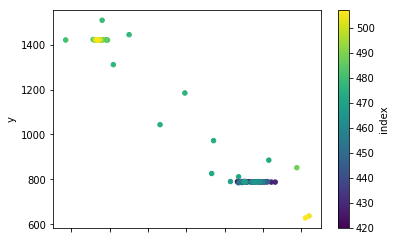

In [123]:
print(frame_to_time(420), frame_to_time(508))
test_df.iloc[420:508]['Pellet'].reset_index().plot(kind='scatter', x='x', y='y', c='index', colormap='viridis')
# plt.xticks([600, 800])

In [91]:
x = sorted(predicted_fails + predicted_reaches + predicted_successes)
print(x)
print(len(x))
import numpy as np
np.savetxt("file_name.csv", x, delimiter=",", fmt='%s', header='times')

[1.977, 3.495, 4.613, 6.006, 10.152, 15.057, 15.674, 17.851, 18.527, 19.595, 20.938, 25.951, 26.777, 28.328, 30.572, 37.187, 38.28, 39.798, 41.758, 43.493, 45.646, 46.605, 48.382, 48.932, 50.275, 51.493, 52.669, 58.642, 60.394, 60.903, 63.822, 68.126, 69.228]
33


In [153]:
test_df2 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N2_V2_2.7k_120FPS_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
test_df2.columns = test_df2.columns.droplevel()
starts = get_classified_starts(attempt_classifier, test_df2)
print(starts)
print(len(starts))
print([(x[0], x[2][-1]) for x in starts])
predicted_fails = [x[0] for x in starts if 'f' in x[1]]
predicted_reaches = [x[0] for x in starts if 'r' in x[1]]
predicted_successes = [x[0] for x in starts if 's' in x[1]]
print(predicted_fails)
print(predicted_reaches)
print(predicted_successes)
x = sorted(predicted_fails + predicted_reaches + predicted_successes)
print(x)
print(len(x))
import numpy as np
np.savetxt("file_name.csv", x, delimiter=",", fmt='%s', header='times')

hihihihi
12
30
(14.214, 'f')
[(14.214, ['f'], ['f']), (32.599, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r']), (41.767, ['s'], ['r', 'r', 'r', 'r', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'f', 'f', 'f', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'f']), (42.634, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', '

Things to try: changing random forest training parameters (max_features, depth, etc)

In [192]:
cols = ['Nose', 'DomInside', 'Pellet', 'Index', 'OtherHand']

frames_before = 15

frames_after = 45

seed = 1

pm = 0

n_feats = (frames_before+frames_after)*15

num_wrong = 0
num_right_times = 0
fp = 0
fn = 0
iters = 30
compiled_features = np.concatenate((featuresA, features_n2v3, features_n3v3, features_injuredn2v3))
compiled_labels = np.concatenate((labelsA, labels_n2v3, labels_n3v3, labels_injuredn2v3))
test_df = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N3_V2_2.7k_120FPS_analyze_trimDeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
test_df.columns = test_df.columns.droplevel()
for i in range(iters):
    seed = random.randint(234, 1000)
    attempt_classifier1 = create_classifier(compiled_features, compiled_labels, 200, test_proportion=0.01)[0]
    print(attempt_classifier1.n_features_, i)

    starts = get_classified_starts(attempt_classifier1, test_df)
    predicted_fails = [x[0] for x in starts if 'f' in x[1]]
    predicted_reaches = [x[0] for x in starts if 'r' in x[1]]
    predicted_successes = [x[0] for x in starts if 's' in x[1]]

    correct_times = find_differences(starts[:], solutions[:], 0.3)
    pred_label_for_correct_times = [x[1][0] for x in correct_times[0]]
    true_label_for_correct_times = [x[1] for x in correct_times[1]]
    num_right_times += len(correct_times[0])
    print(len(correct_times[0]))
    print()
    guessed_labels = [x[1][0] for x in correct_times[0]]
    true_labels = [x[1] for x in correct_times[1]]
    # grouped_labels = pd.DataFrame(list(zip(guessed_labels, true_labels), columns = ['guess', 'actual'])
    # grouped_labels.groupby(grouped_labels.columns.tolist(),as_index=False).size()

    wrong_ones = [correct_times[0][i][1][0] for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
    wrong_ones_correct = [correct_times[1][i][1] for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
    num_wrong += len(wrong_ones)
    print(num_wrong)
    wrong_df = pd.DataFrame(list(zip(wrong_ones, wrong_ones_correct)), columns = ['guess', 'actual'])
    wrong_df.groupby(wrong_df.columns.tolist(),as_index=False).size()
print(num_wrong/iters)
print(num_right_times/iters)

Training Features Shape: (213, 900)
Training Labels Shape: (213,)
Testing Features Shape: (3, 900)
Testing Labels Shape: (3,)
(213, 900)
(213,)
['s' 'n' 'f']
['s' 'n' 'f']
Wrong Labels []
900 0
hihihihi
15
45
(1.994, 'r')
false positives:  [(2.911, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (3.328, ['r'], ['r', 'r', 'r', 'f']), (5.005, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (11.879, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r']), (20.946, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (38.272, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (50.25, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r

['f' 'f' 'r']
['s' 'f' 's']
Wrong Labels [('f', 's'), ('r', 's')]
900 5
hihihihi
15
45
(1.994, 'r')
TIE:  ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'r']
false positives:  [(2.911, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (3.345, ['r'], ['r', 'r', 'r', 'r', 'f']), (20.954, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (27.311, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r']), (38.28, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (40.849, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 

['n' 's' 'f']
['n' 's' 'f']
Wrong Labels []
900 10
hihihihi
15
45
(1.518, 'f')
false positives:  [(1.518, ['f'], ['f']), (3.337, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'f']), (20.954, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (38.28, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (40.883, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (50.267, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r'

['r' 'n' 'f']
['r' 'n' 'f']
Wrong Labels []
900 15
hihihihi
15
45
(1.994, 'r')
TIE:  ['r', 'f']
false positives:  [(2.895, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (3.278, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'f']), (11.854, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r']), (20.946, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (26.81, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r']), (27.294, ['r'], ['r']), (38.28, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (40.832, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',

['n' 'f' 'f']
['n' 'f' 'f']
Wrong Labels []
900 20
hihihihi
15
45
(1.994, 'r')
false positives:  [(2.903, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (3.303, ['r'], ['r', 'r', 'r', 'r', 'f']), (20.954, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (38.28, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (40.883, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (50.25, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',

['f' 'r' 'n']
['f' 'r' 'n']
Wrong Labels []
900 25
hihihihi
15
45
(1.994, 'r')
TIE:  ['r', 'f']
false positives:  [(2.911, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (3.278, ['f'], ['f']), (11.862, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r']), (20.954, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (38.28, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (50.275, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (52.327, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r

In [ ]:
print(int(n_feats**0.5))

In [95]:
#Functions to get training data
def get_dataset2(df, start_frames):
    dataframe = df[cols]
    dataset = []
    for start_f in start_frames:
        temp_df = dataframe.iloc[start_f - frames_before: start_f + frames_after]
        if len(temp_df.values.flatten()) == 0:
            print("ERROR check get dataset")
        dataset.append(temp_df.values)
    return np.asarray(dataset)

pm = 0
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None
#"C:\Users\vjj14\Documents\GoProLens\3lens\gp2.7k3lensA1.mp4"
df_A = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\gp2.7k3lensA1DeepCut_resnet50_gopro3lensJul8shuffle1_120005.h5")
df_A.columns = df_A.columns.droplevel()
reach_times = [19.12, 23.752, 24.186, 24.630, 36.846, 43.652, 44.042, 46.964, 60.218, 62.897, 64.787, 72.045, 85.174, 88.196, 
           91.652, 93.248, 93.814, 106.294, 106.867, 111.344, 112.249, 113.407, 115.474, 115.918, 129.119, 136.837, 138.581]
reach_frames = [time_to_frame(x) for x in reach_times]
reach_labels = ['r', 'f', 'r', 'r', 's', 'f', 's', 'r', 's', 'r', 'r', 'r', 's', 'r', 's', 'r', 'r', 'r', 'f', 'r', 'r', 
                      'r', 'f', 'r', 's', 'r', 'r']
non_reaches_frames = get_non_reach_frames(df_A, len(reach_frames)//2, reach_frames, 12)
featuresA = get_dataset2(df_A, reach_frames+non_reaches_frames)
labelsA = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
elabelsA = pd.Series(labelsA)
encoded_labels = pd.get_dummies(elabelsA)
reach_frames, reach_frames, reach_labels, non_reaches_frames = None, None, None, None
encoded_labels

,f,n,r,s
0,0,0,1,0
1,1,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,0,1
5,1,0,0,0
6,0,0,0,1
7,0,0,1,0
8,0,0,0,1
9,0,0,1,0


In [20]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)
# model = Sequential()
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(13, activation='softmax'))
n_steps = 1
model = Sequential()
model.add(LSTM(32, input_shape=(77, 15)))
model.add(Dense(1))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

lstm_classifier = model.fit(featuresA, labelsA, validation_split=0.15)

Using TensorFlow backend.


Train on 102 samples, validate on 19 samples
Epoch 1/1


ValueError: could not convert string to float: 's'

# Data Preprocessing
### leaky integrator

In [7]:
def next_val(current, lmbda, prev):
    return lmbda*prev + (1-lmbda)*current
def leaky_integrate(series, lmbda):
    prev = series[0]
    output = [series[0]]
    for i in range(1, len(series)):
        curr = series[i]
        prev = output[-1]
        output.append(lmbda*prev + (1-lmbda)*curr)
    return output
test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
test = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 100, 5, 5, 5, 5, 5, 5, 5, 5, 100, 5, 5, 5, 5, 5]
leaky_integrate(test, 0.3)
def 

[5,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 71.5,
 24.95,
 10.985,
 6.7955,
 5.53865,
 5.161595,
 5.0484785,
 5.01454355,
 5.004363065,
 71.5013089195,
 24.95039267585,
 10.985117802755,
 6.7955353408265,
 5.538660602247949,
 5.1615981806743845]

In [17]:
list(range(0, 1.0, 0.1))

TypeError: 'float' object cannot be interpreted as an integer

In [54]:
n3v3 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N3_V3_2.7k_120FPS_Label_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120003.h5")
n3v3.columns = n3v3.columns.droplevel()
n3v3.describe(percentiles=[.25, .5, .6, .7, .75, .85, .90, .98])

bodyparts          Nose                                    Pellet  \
coords                x             y    likelihood             x   
count      25677.000000  25677.000000  25677.000000  25677.000000   
mean        1453.965431    450.733349      0.389417   1402.579276   
std          446.532101    333.966582      0.376025    165.787077   
min           -0.354489     -1.677021      0.000734     13.004647   
25%         1334.096058    194.416606      0.040618   1381.615732   
50%         1385.983011    398.700827      0.211678   1382.489145   
60%         1416.222581    496.599183      0.460811   1385.478930   
70%         1430.989045    592.125929      0.720457   1396.366711   
75%         1483.704995    652.028958      0.816693   1402.400355   
85%         1549.241903    735.431279      0.915742   1410.025703   
90%         1732.677436    765.246605      0.943315   1442.148001   
98%         2685.999395   1293.164227      0.977576   1861.428204   
max         2703.749926   1518.702819      0.995878   2387.607508   

bodyparts                                 DomInside                \
coords                y    likelihood             x             y   
count      25677.000000  25677.000000  25677.000000  25677.000000   
mean        1037.934730      0.412287   1937.189304    795.003896   
std          390.235212      0.329233    719.548874    469.595200   
min           -1.217455      0.013498     -1.374080     -1.666209   
25%          742.754845      0.123933   1360.515198    365.033464   
50%         1359.199602      0.257029   1584.776216    716.786559   
60%         1360.069719      0.403910   2681.397552   1274.725128   
70%         1360.759192      0.692673   2682.259007   1275.542315   
75%         1361.267036      0.768586   2682.669204   1275.825480   
85%         1362.170510      0.880170   2691.115391   1276.399247   
90%         1362.615621      0.913013   2696.605546   1276.796312   
98%         1454.261703      0.965798   2697.950495   1290.329048   
max         1519.674246      0.996796   2702.945790   1451.604247   

bodyparts                  DomOutside      ...             Middle  \
coords       likelihood             x      ...         likelihood   
count      25677.000000  25677.000000      ...       25677.000000   
mean           0.051560   1680.415357      ...           0.208193   
std            0.131570    658.873204      ...           0.271242   
min            0.000207     -0.098147      ...           0.000222   
25%            0.012487   1335.299677      ...           0.031290   
50%            0.019400   1398.018042      ...           0.073609   
60%            0.023517   1435.004948      ...           0.109773   
70%            0.029432   1611.516606      ...           0.189608   
75%            0.033847   2682.838010      ...           0.273581   
85%            0.049346   2683.758201      ...           0.534492   
90%            0.070478   2684.294616      ...           0.709923   
98%            0.647476   2699.987164      ...           0.943166   
max            0.982956   2701.585605      ...           0.997337   

bodyparts          Ring                                     Pinky  \
coords                x             y    likelihood             x   
count      25677.000000  25677.000000  25677.000000  25677.000000   
mean        1365.983508    509.781430      0.127018   1359.434216   
std          556.209236    346.417739      0.214245    523.269623   
min           -1.765308     -1.057546      0.000403     -2.257651   
25%         1243.239815    221.833550      0.013070   1176.936571   
50%         1337.768260    462.540989      0.037547   1354.404820   
60%         1370.775070    553.357933      0.051873   1384.933383   
70%         1387.830406    661.478844      0.079256   1399.964059   
75%         1402.322021    717.825257      0.109605   1402.741584   
85%         1534.177645    768.012069      0.257323   1531.010979   
90%         2257.504158    944.717131      0.420000   1864.06943

In [51]:
frame_to_time(730)

6.089

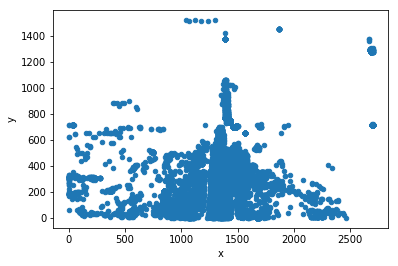

In [56]:
n3v3['Nose'].plot(kind='scatter', x='x', y='y')

In [ ]:
from scipy import stats 
def reduce_error(part):
    copy = part.copy()
    print(copy['x'][76])
    for i in range(copy.shape[0]):
        likelihood = part['likelihood'][i]
        if likelihood < 0.1:
            new_coords = get_replacement(copy, i)
            part['x'][i] = new_coords[0]
            part['y'][i] = new_coords[1]
    return
def get_replacement(df, index):
    likelihoods = df['likelihood']
    closest_right = index
    while likelihoods[closest_right] < .5:
        closest_right += 1
    closest_left = index
    while likelihoods[closest_left] < .5:
        closest_left -= 1
    spread = closest_right - closest_left
    new_x = ((closest_right - index)/spread) * df['x'][closest_right] + ((index - closest_left)/spread)*df['x'][closest_left]
    new_y = ((closest_right - index)/spread) * df['y'][closest_right] + ((index - closest_left)/spread)*df['y'][closest_left]
    return (new_x, new_y)
reduce_error(n3v3['Nose'])
n3v3.describe()

1336.732534646988


C:\Users\vjj14\.conda\envs\dlc-windowsGPU\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
